## MCMC sampling

In this example, we show how to sample our trained surrogate model using both the `emcee` and `dynesty` samplers. 

In [6]:
%matplotlib inline
from functools import partial
import alabi

First, we need to define the same function that was used when creating the cached model, then we can reload our results from the previous tutorial:

In [ ]:
# Redefine in this notebook so that pickle file can be loaded
from scipy.optimize import rosen

def rosenbrock_fn(x):
    return -rosen(x)/100.0

bounds = [(-5,5), (-5,5)]
param_names = ['x1', 'x2']

In [9]:
sm = alabi.load_model_cache("results/rosenbrock_2d")

### Sampling with `emcee`

First, let's run emcee with default settings (uniform prior):

In [ ]:
import alabi.utility as ut

# In this example we will set up a uniform prior within the parameter bounds
prior_fn = partial(ut.lnprior_uniform, bounds=sm.bounds)  # Use bounds from loaded model

sm.run_emcee(
    like_fn=sm.surrogate_log_likelihood,    # use like_fn=sm.true_log_likelihood to sample the true function
    prior_fn=prior_fn,                      # if None, defaults to uniform prior within bounds
    nwalkers=10,
    nsteps=int(2e4),
    burn=int(1e3),
    multi_proc=True,
)

Running emcee with 10 walkers for 20000 steps on 4 cores...


100%|██████████| 20000/20000 [08:11<00:00, 40.69it/s]


burn-in estimate: 311
thin estimate: 35

Total samples: 5420
Mean acceptance fraction: 0.534
Mean autocorrelation time: 113.534 steps
Caching model to results/rosenbrock_2d/surrogate_model...


Plotting emcee posterior...


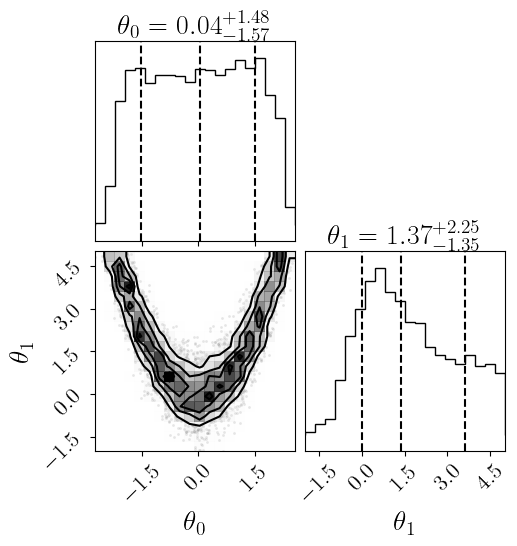

In [ ]:
sm.plot(plots=["emcee_corner"]);

### Sampling with `dynesty`

Now let's use the `dynesty` nested sampler for comparison with default settings (uniform prior):

In [ ]:
# Set up uniform prior - dynesty requires separate prior transform function
prior_transform = partial(ut.prior_transform_uniform, bounds=sm.bounds)  # Use bounds from loaded model

dynesty_sampler_kwargs = {"bound": "single",
                          "nlive": 100,
                          "sample": "auto"}

dynesty_run_kwargs = {"wt_kwargs": {'pfrac': 1.0},      # set weights to 100% posterior, 0% evidence
                      "stop_kwargs": {'pfrac': 1.0},
                      "maxiter": int(2e4),
                      "dlogz_init": 0.5}
    
sm.run_dynesty(like_fn=sm.surrogate_log_likelihood,    # use like_fn=sm.true_log_likelihood to sample the true function
               prior_transform=prior_transform,        # if None, defaults to uniform prior within bounds
               multi_proc=False,                       # optional parallelization (oftentimes not worth it for dynesty)
               sampler_kwargs=dynesty_sampler_kwargs, 
               run_kwargs=dynesty_run_kwargs)

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 100 live points on 1 cores...


10654it [04:03, 43.80it/s, batch: 42 | bound: 6 | nc: 1 | ncall: 92629 | eff(%): 11.421 | loglstar: -2.290 <  0.001 < -0.183 | logz: -2.557 +/-  0.041 | stop:  0.982]         

Caching model to results/rosenbrock_2d/surrogate_model...


Plotting dynesty posterior...


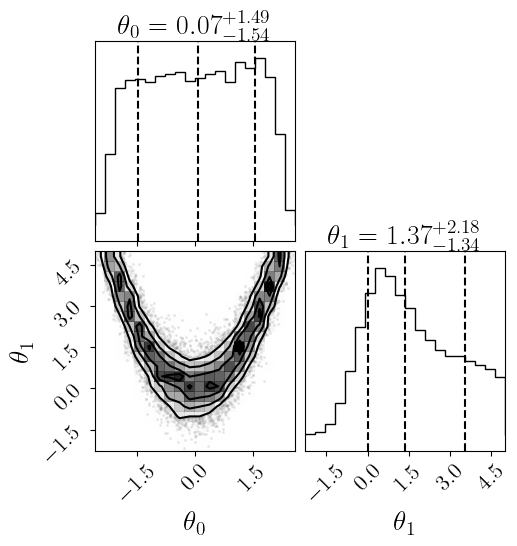

In [22]:
sm.plot(plots=["dynesty_corner"]);

Plotting dynesty traceplot...


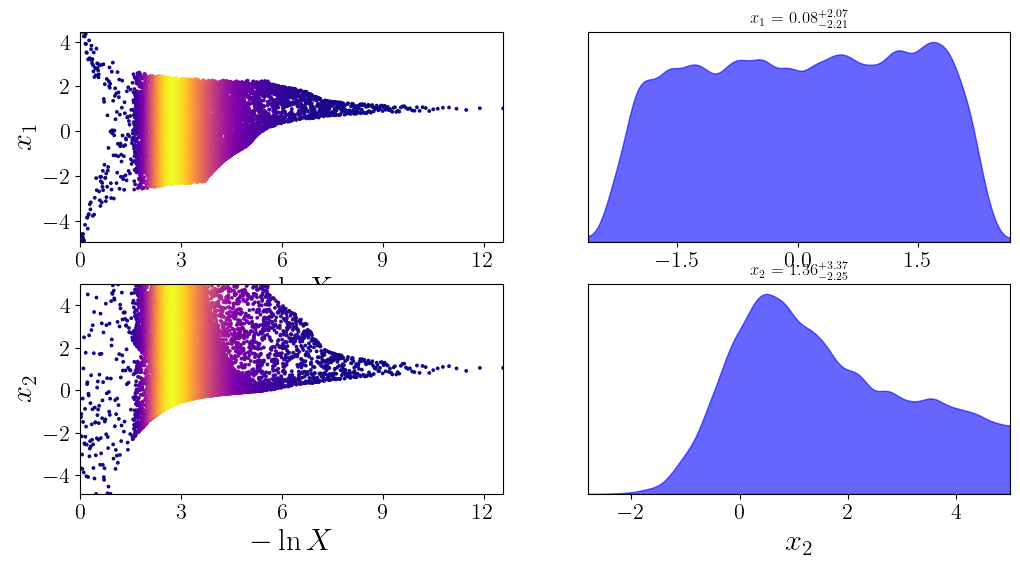

In [24]:
sm.plot(plots=["dynesty_traceplot"]);

Plotting dynesty runplot...


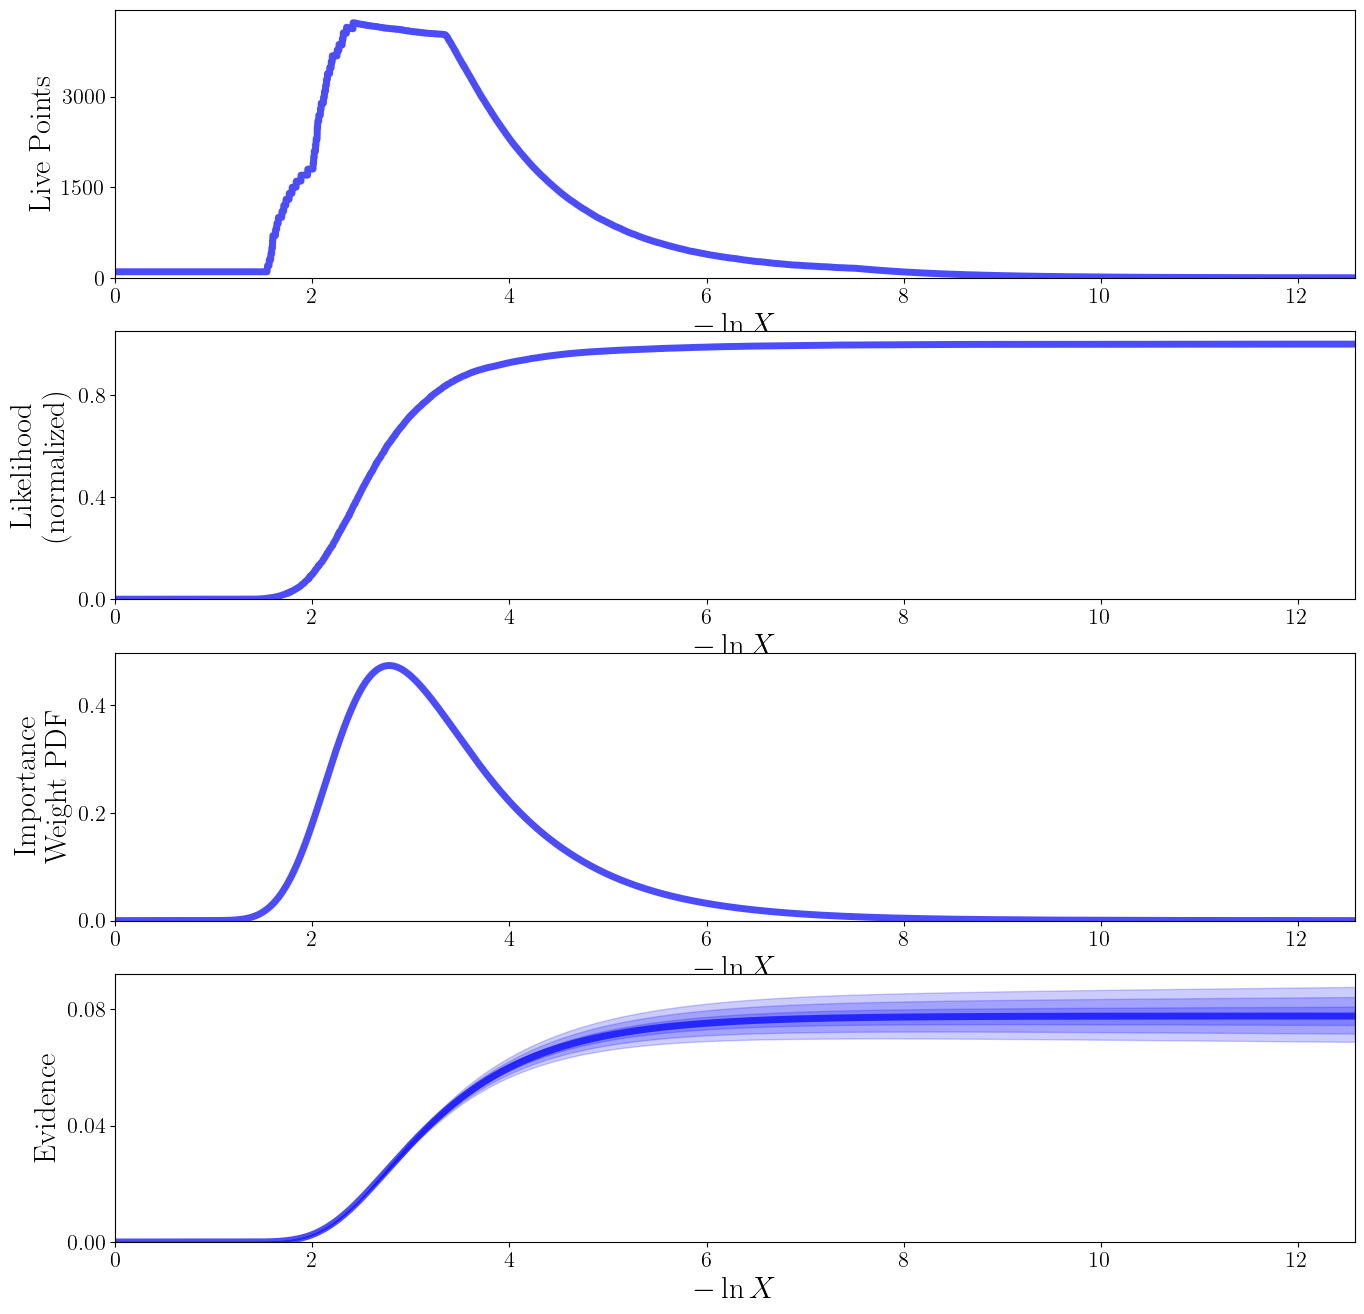

In [27]:
sm.plot(plots=["dynesty_runplot"]);

Compare the results from both samplers:

Plotting emcee vs dynesty posterior comparison...


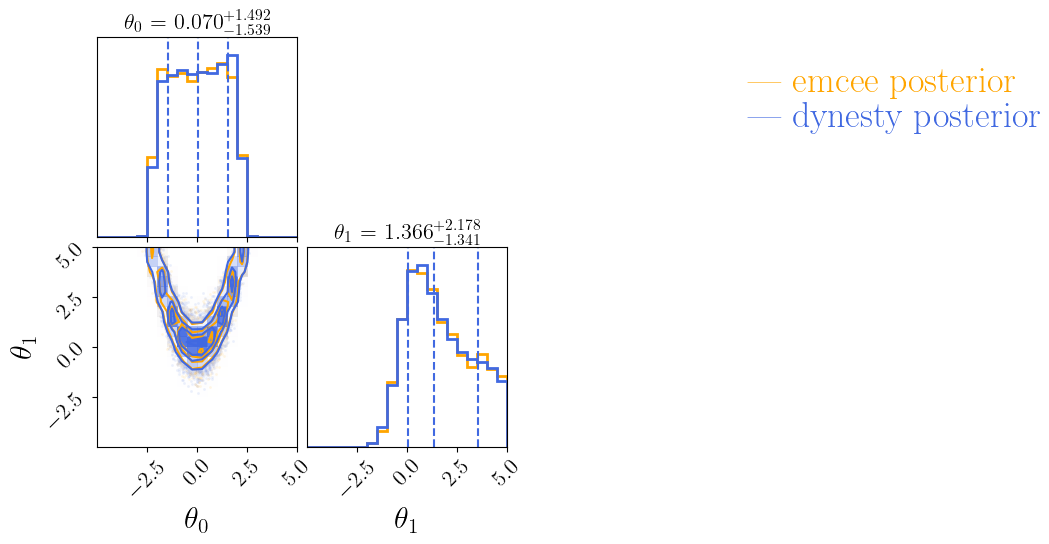

In [26]:
sm.plot(plots=["mcmc_comparison"]);

Both samplers achieve similar results for this example!